<a href="https://colab.research.google.com/github/lcaspari/42_tensorflow_homework/blob/Melih/homework8/GAN_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset

In [6]:
# Load the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
# === Hyperparameters === #
batch_size = 256        
# ========================#

'''train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
train_dataset = train_dataset.map(lambda img : tf.cast(img/255, tf.float32))
#train_dataset = train_dataset.batch(batch_size)'''

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 # total image size

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(batch_size)



# Discriminator

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [9]:
class Discriminator(tf.keras.Model):
    def __init__(self, input_shape = (28,28,1)):
        super(Discriminator, self).__init__()

        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2)

        self.conv_64_input = tf.keras.layers.Conv2D(
            filters = 64,
            kernel_size = (3,3),
            strides = (2,2),
            padding = 'same',
            input_shape = input_shape)
        
        self.conv_64 = tf.keras.layers.Conv2D(
            filters = 64,
            kernel_size = (3,3),
            strides = (2,2),
            padding = 'same')
        
        self.dropout = tf.keras.layers.Dropout(0.4)

        self.flatten = tf.keras.layers.Flatten()

        self.dense = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def call(self, x):
        x = self.conv_64_input(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv_64(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

# Generator

In [10]:
class Generator(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2)

        self.dense = tf.keras.layers.Dense(128 * 7 * 7, input_dim = latent_dim)

        self.reshape = tf.keras.layers.Reshape((7,7,128))

        self.conv_2D_trans = tf.keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = (4,4),
            strides = (2,2),
            padding = 'same'
        )

        self.conv_2D = tf.keras.layers.Conv2D(
            filters = 1,
            kernel_size = (7,7),
            activation = 'sigmoid',
            padding = 'same'
        )

    def call(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.reshape(x)
        x = self.conv_2D_trans(x)
        x = self.leaky_relu(x)
        x = self.conv_2D_trans(x)
        x = self.leaky_relu(x)
        x = self.conv_2D(x)
        return x

In [11]:
# generate real images
def generate_real_images(dataset, n_samples):
    i = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[i]
    X = np.expand_dims(X, axis = -1)
    X = X.astype('float32')
    #y = np.ones((n_samples, 1))
    return X

# generate point from latent space
def generate_latent_points(latent_dim, n_samples):
    x = np.random.randn(latent_dim * n_samples)
    x = x.reshape(n_samples, latent_dim)
    return x

# generate fake images from gaussian
def generate_fake_images(generator, latent_dim, n_samples):
    x = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x)
    #y = np.zeros((n_samples, 1))
    return X

# GAN

In [12]:
class GAN(tf.keras.Model):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = Discriminator()
        self.generator = Generator(latent_dim)

    def call(self, x):
        discriminator.trainable = False
        x = discriminator(x)
        x = generator(x)
        return x

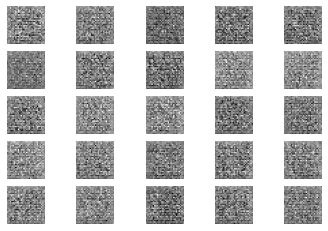

In [13]:
# latent space size
latent_dim = 100
# number of generated samples
n_samples = 25

model = Generator(latent_dim)
X = generate_fake_images(model, latent_dim, n_samples)
for i in range(n_samples):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap = 'gray_r')
plt.show()

# Training

In [14]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(d_pred): 
  """
  d_pred: discriminator's prediction  of the image generated by the generator  
  take cross entropy between predicted label and all labels as 1s
  because we want to minimize the difference between them
  --> the more the discriminator thinks the images are real, the better our generator
  """
  return bce(tf.ones_like(d_pred), d_pred) # tf.ones_like(d_pred) is same as tf.ones(d_pred.shape)


def discriminator_loss(real_img_lbl, fake_img_lbl):
  """
  real_img_lbl: labels that discriminator predicted when seeing real images (should ideally be all 1s)
  fake_img_lbl: labels that discriminator predicted when seeing fake images (should ideally be all 0s)
  """
  real_loss = bce(tf.ones(real_img_lbl.shape), real_img_lbl)
  fake_loss = bce(tf.zeros(fake_img_lbl.shape), fake_img_lbl)

  return real_loss + fake_loss



In [15]:
# def training step(generator, discriminator, real_images):

  # create noise
  # feed into generator

  # Create images from random noise
  # randomly select real images
  
  # calculate discr loss 
  # apply the gradients

  # calc gen loss
  # apply gradients 

  # return both losses
  
@tf.function
def train_step(images):

    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

        #print('1: Creating fake Images')
        fake_images = generator(noise)

        # feed real images into discriminator, get the predictions
        #print('2: ' + str(fake_images.shape))
        prediction_fake = discriminator(fake_images)
        
        # feed fake images into discriminator, get the predictions
        #print('3: ' + str(images.shape))
        prediction_real = discriminator(images)

        # calculate discriminator loss
        d_loss = discriminator_loss(prediction_fake, prediction_real)
        #print('4: ' + str(d_loss))

        # apply the gradients
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
        #print('5: applying discriminator gradient')
        
        # calculate generator loss
        g_loss = generator_loss(prediction_fake)
        #print('6:' + str(g_loss))

        # apply the gradients
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        #print('7:' + str(g_gradients))
        
        optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
        #print('8')

    return d_loss, g_loss

def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


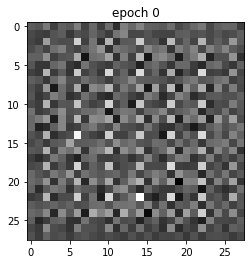

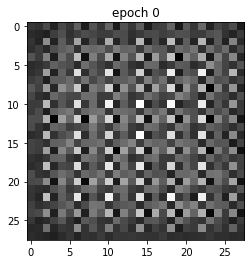

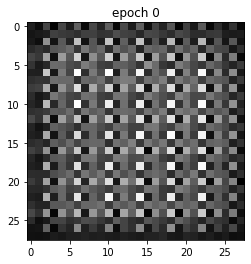

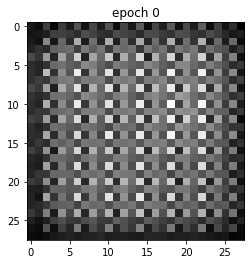

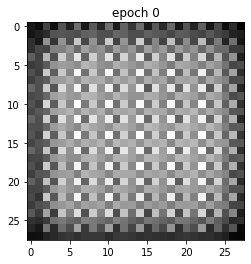

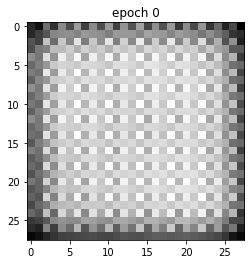

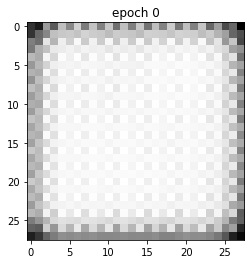

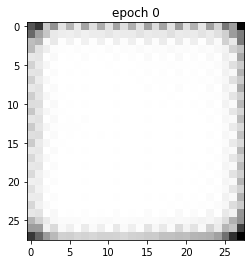

In [ ]:
import datetime
import matplotlib.pyplot as plt
import time

# Tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# === Hyperparameters === #
epochs = 10
learning_rate = 0.01
run_avg_factor = 0.95

latent_dim = 100
# === =============== === #

discriminator = Discriminator()
generator = Generator(latent_dim)

loss = tf.keras.losses.BinaryCrossentropy
optimizer = tf.keras.optimizers.Adam()

for epoch in range(epochs):
    start = time.time()

    for image_batch in train_dataset:
      train_step(image_batch)
      
      noise = tf.random.normal([1, 100])
      generated_image = generator(noise, training=False)

      plt.imshow(generated_image[0, :, :, 0], cmap='gray')
      plt.title(f"epoch {epoch}")
      plt.show()

      


'''
    # Create images from random noise
    (Fake, label_fake) = generate_fake_images(generator, latent_dim, 32)
    # randomly select real images
    (Real, label_real) = generate_real_images(train_dataset, 32)
    # Concatenate to one stack
    (image, label) = (np.concatenate((Fake,Real), 0), np.concatenate((label_fake, label_real), 0))

    dataset = tf.data.Dataset.from_tensor_slices((image, label))
    dataset = dataset.shuffle(buffer_size = 64)

    d_test_loss, d_test_accuracy = test(discriminator, dataset, loss)    
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', d_test_loss, step=epoch)
        tf.summary.scalar('accuracy', d_test_accuracy, step=epoch)

    # === Train Generator === #

'''